In [ ]:
https://jakevdp.github.io/blog/2012/10/07/xkcd-style-plots-in-matplotlib/

In [2]:
"""
XKCD plot generator
-------------------
Author: Jake Vanderplas

This is a script that will take any matplotlib line diagram, and convert it
to an XKCD-style plot.  It will work for plots with line & text elements,
including axes labels and titles (but not axes tick labels).

The idea for this comes from work by Damon McDougall
  http://www.mail-archive.com/matplotlib-users@lists.sourceforge.net/msg25499.html
"""
import numpy as np
import pylab as pl
from scipy import interpolate, signal
import matplotlib.font_manager as fm


# We need a special font for the code below.  It can be downloaded this way:
import os
import urllib.request as urllib2
if not os.path.exists('Humor-Sans.ttf'):
    fhandle = urllib2.urlopen('http://antiyawn.com/uploads/Humor-Sans-1.0.ttf')
    open('Humor-Sans.ttf', 'wb').write(fhandle.read())

    
def xkcd_line(x, y, xlim=None, ylim=None,
              mag=1.0, f1=30, f2=0.05, f3=15):
    """
    Mimic a hand-drawn line from (x, y) data

    Parameters
    ----------
    x, y : array_like
        arrays to be modified
    xlim, ylim : data range
        the assumed plot range for the modification.  If not specified,
        they will be guessed from the  data
    mag : float
        magnitude of distortions
    f1, f2, f3 : int, float, int
        filtering parameters.  f1 gives the size of the window, f2 gives
        the high-frequency cutoff, f3 gives the size of the filter
    
    Returns
    -------
    x, y : ndarrays
        The modified lines
    """
    x = np.asarray(x)
    y = np.asarray(y)
    
    # get limits for rescaling
    if xlim is None:
        xlim = (x.min(), x.max())
    if ylim is None:
        ylim = (y.min(), y.max())

    if xlim[1] == xlim[0]:
        xlim = ylim
        
    if ylim[1] == ylim[0]:
        ylim = xlim

    # scale the data
    x_scaled = (x - xlim[0]) * 1. / (xlim[1] - xlim[0])
    y_scaled = (y - ylim[0]) * 1. / (ylim[1] - ylim[0])

    # compute the total distance along the path
    dx = x_scaled[1:] - x_scaled[:-1]
    dy = y_scaled[1:] - y_scaled[:-1]
    dist_tot = np.sum(np.sqrt(dx * dx + dy * dy))

    # number of interpolated points is proportional to the distance
    Nu = int(200 * dist_tot)
    u = np.arange(-1, Nu + 1) * 1. / (Nu - 1)

    # interpolate curve at sampled points
    k = min(3, len(x) - 1)
    res = interpolate.splprep([x_scaled, y_scaled], s=0, k=k)
    x_int, y_int = interpolate.splev(u, res[0]) 

    # we'll perturb perpendicular to the drawn line
    dx = x_int[2:] - x_int[:-2]
    dy = y_int[2:] - y_int[:-2]
    dist = np.sqrt(dx * dx + dy * dy)

    # create a filtered perturbation
    coeffs = mag * np.random.normal(0, 0.01, len(x_int) - 2)
    b = signal.firwin(f1, f2 * dist_tot, window=('kaiser', f3))
    response = signal.lfilter(b, 1, coeffs)

    x_int[1:-1] += response * dy / dist
    y_int[1:-1] += response * dx / dist

    # un-scale data
    x_int = x_int[1:-1] * (xlim[1] - xlim[0]) + xlim[0]
    y_int = y_int[1:-1] * (ylim[1] - ylim[0]) + ylim[0]
    
    return x_int, y_int


def XKCDify(ax, mag=1.0,
            f1=50, f2=0.01, f3=15,
            bgcolor='w',
            xaxis_loc=None,
            yaxis_loc=None,
            xaxis_arrow='+',
            yaxis_arrow='+',
            ax_extend=0.1,
            expand_axes=False):
    """Make axis look hand-drawn

    This adjusts all lines, text, legends, and axes in the figure to look
    like xkcd plots.  Other plot elements are not modified.
    
    Parameters
    ----------
    ax : Axes instance
        the axes to be modified.
    mag : float
        the magnitude of the distortion
    f1, f2, f3 : int, float, int
        filtering parameters.  f1 gives the size of the window, f2 gives
        the high-frequency cutoff, f3 gives the size of the filter
    xaxis_loc, yaxis_log : float
        The locations to draw the x and y axes.  If not specified, they
        will be drawn from the bottom left of the plot
    xaxis_arrow, yaxis_arrow : str
        where to draw arrows on the x/y axes.  Options are '+', '-', '+-', or ''
    ax_extend : float
        How far (fractionally) to extend the drawn axes beyond the original
        axes limits
    expand_axes : bool
        if True, then expand axes to fill the figure (useful if there is only
        a single axes in the figure)
    """
    # Get axes aspect
    ext = ax.get_window_extent().extents
    aspect = (ext[3] - ext[1]) / (ext[2] - ext[0])

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xspan = xlim[1] - xlim[0]
    yspan = ylim[1] - xlim[0]

    xax_lim = (xlim[0] - ax_extend * xspan,
               xlim[1] + ax_extend * xspan)
    yax_lim = (ylim[0] - ax_extend * yspan,
               ylim[1] + ax_extend * yspan)

    if xaxis_loc is None:
        xaxis_loc = ylim[0]

    if yaxis_loc is None:
        yaxis_loc = xlim[0]

    # Draw axes
    xaxis = pl.Line2D([xax_lim[0], xax_lim[1]], [xaxis_loc, xaxis_loc],
                      linestyle='-', color='k')
    yaxis = pl.Line2D([yaxis_loc, yaxis_loc], [yax_lim[0], yax_lim[1]],
                      linestyle='-', color='k')

    # Label axes3, 0.5, 'hello', fontsize=14)
    ax.text(xax_lim[1], xaxis_loc - 0.02 * yspan, ax.get_xlabel(),
            fontsize=14, ha='right', va='top', rotation=12)
    ax.text(yaxis_loc - 0.02 * xspan, yax_lim[1], ax.get_ylabel(),
            fontsize=14, ha='right', va='top', rotation=78)
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Add title
    ax.text(0.5 * (xax_lim[1] + xax_lim[0]), yax_lim[1],
            ax.get_title(),
            ha='center', va='bottom', fontsize=16)
    ax.set_title('')

    Nlines = len(ax.lines)
    lines = [xaxis, yaxis] + [ax.lines.pop(0) for i in range(Nlines)]

    for line in lines:
        x, y = line.get_data()

        x_int, y_int = xkcd_line(x, y, xlim, ylim,
                                 mag, f1, f2, f3)

        # create foreground and background line
        lw = line.get_linewidth()
        line.set_linewidth(2 * lw)
        line.set_data(x_int, y_int)

        # don't add background line for axes
        if (line is not xaxis) and (line is not yaxis):
            line_bg = pl.Line2D(x_int, y_int, color=bgcolor,
                                linewidth=8 * lw)

            ax.add_line(line_bg)
        ax.add_line(line)

    # Draw arrow-heads at the end of axes lines
    arr1 = 0.03 * np.array([-1, 0, -1])
    arr2 = 0.02 * np.array([-1, 0, 1])

    arr1[::2] += np.random.normal(0, 0.005, 2)
    arr2[::2] += np.random.normal(0, 0.005, 2)

    x, y = xaxis.get_data()
    if '+' in str(xaxis_arrow):
        ax.plot(x[-1] + arr1 * xspan * aspect,
                y[-1] + arr2 * yspan,
                color='k', lw=2)
    if '-' in str(xaxis_arrow):
        ax.plot(x[0] - arr1 * xspan * aspect,
                y[0] - arr2 * yspan,
                color='k', lw=2)

    x, y = yaxis.get_data()
    if '+' in str(yaxis_arrow):
        ax.plot(x[-1] + arr2 * xspan * aspect,
                y[-1] + arr1 * yspan,
                color='k', lw=2)
    if '-' in str(yaxis_arrow):
        ax.plot(x[0] - arr2 * xspan * aspect,
                y[0] - arr1 * yspan,
                color='k', lw=2)

    # Change all the fonts to humor-sans.
    prop = fm.FontProperties(fname='Humor-Sans.ttf', size=16)
    for text in ax.texts:
        text.set_fontproperties(prop)
    
    # modify legend
    leg = ax.get_legend()
    if leg is not None:
        leg.set_frame_on(False)
        
        for child in leg.get_children():
            if isinstance(child, pl.Line2D):
                x, y = child.get_data()
                child.set_data(xkcd_line(x, y, mag=10, f1=100, f2=0.001))
                child.set_linewidth(2 * child.get_linewidth())
            if isinstance(child, pl.Text):
                child.set_fontproperties(prop)
    
    # Set the axis limits
    ax.set_xlim(xax_lim[0] - 0.1 * xspan,
                xax_lim[1] + 0.1 * xspan)
    ax.set_ylim(yax_lim[0] - 0.1 * yspan,
                yax_lim[1] + 0.1 * yspan)

    # adjust the axes
    ax.set_xticks([])
    ax.set_yticks([])      

    if expand_axes:
        ax.figure.set_facecolor(bgcolor)
        ax.set_axis_off()
        ax.set_position([0, 0, 1, 1])
    
    return ax

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

<AxesSubplot:>

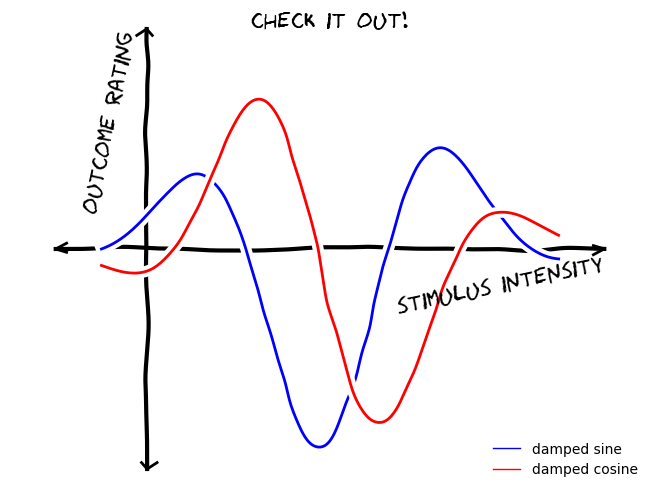

In [6]:
np.random.seed(0)

ax = plt.axes()

x = np.linspace(0, 10, 100)
ax.plot(x, np.sin(x) * np.exp(-0.1 * (x - 5) ** 2), 'b', lw=1, label='damped sine')
ax.plot(x, -np.cos(x) * np.exp(-0.1 * (x - 5) ** 2), 'r', lw=1, label='damped cosine')

ax.set_title('check it out!')
ax.set_xlabel('stimulus intensity')
ax.set_ylabel('outcome rating')

ax.legend(loc='lower right')

ax.set_xlim(0, 10)
ax.set_ylim(-1.0, 1.0)

#XKCDify the axes -- this operates in-place
XKCDify(ax, xaxis_loc=0.0, yaxis_loc=1.0,
        xaxis_arrow='+-', yaxis_arrow='+-',
        expand_axes=True)

<AxesSubplot:>

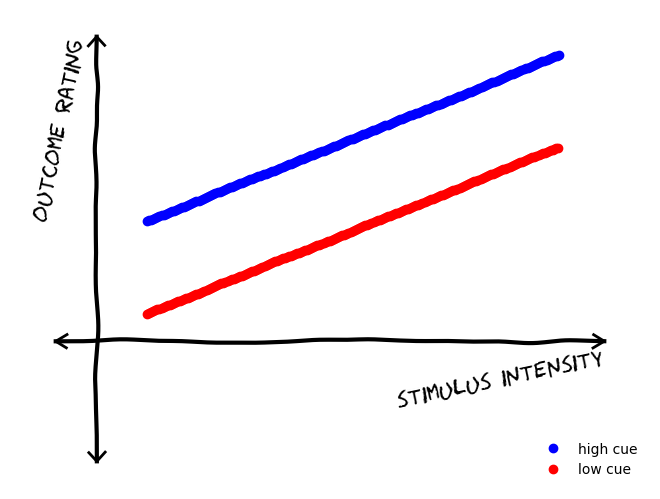

In [34]:
np.random.seed(0)

ax = plt.axes()

x = np.linspace(1, 10, 100)
ax.plot(x, x*0.2+1.1, 'bo', lw=3, label='high cue')
ax.plot(x, x*0.2+0.1, 'ro', lw=3, label='low cue')

#ax.set_title('Different cues drive different outcome ratings')
ax.set_xlabel('stimulus intensity')
ax.set_ylabel('outcome rating')

ax.legend(loc='lower right')

ax.set_xlim(0, 10)
ax.set_ylim(-1.0, 3)

#XKCDify the axes -- this operates in-place
XKCDify(ax, xaxis_loc=0.0, yaxis_loc=-0.1,
        xaxis_arrow='+-', yaxis_arrow='+-',
        expand_axes=True)

<AxesSubplot:>

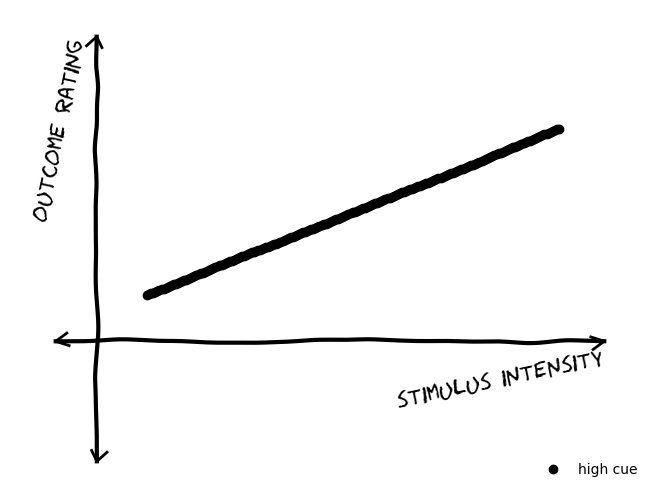

In [38]:
np.random.seed(0)

ax = plt.axes()

x = np.linspace(1, 10, 100)
ax.plot(x, x*0.2+0.3, 'ko', lw=3, label='high cue')

# ax.plot(x, x*0.2+0.1, 'ro', lw=3, label='low cue')

#ax.set_title('Different cues drive different outcome ratings')
ax.set_xlabel('stimulus intensity')
ax.set_ylabel('outcome rating')

ax.legend(loc='lower right')

ax.set_xlim(0, 10)
ax.set_ylim(-1.0, 3)

#XKCDify the axes -- this operates in-place
XKCDify(ax, xaxis_loc=0.0, yaxis_loc=-0.1,
        xaxis_arrow='+-', yaxis_arrow='+-',
        expand_axes=True)

outcome rating ~ cue

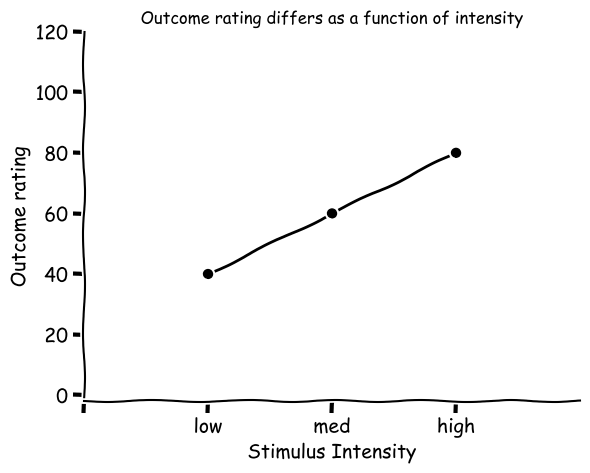

In [83]:
import matplotlib.pyplot as plt

data = {'':np.nan,'low': 40, 'med': 60, 'high': 80}
names = list(data.keys())
values = list(data.values())

with plt.xkcd():
    fig, ax = plt.subplots()
    plt.plot(names, values,marker="o", color = "k")

plt.xlabel("Stimulus Intensity")
plt.ylabel("Outcome rating")
plt.ylim(-2, 120)
plt.xlim(0,4)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.title("Outcome rating differs as a function of intensity")
plt.show()

# outcome rating ~ cue * stim

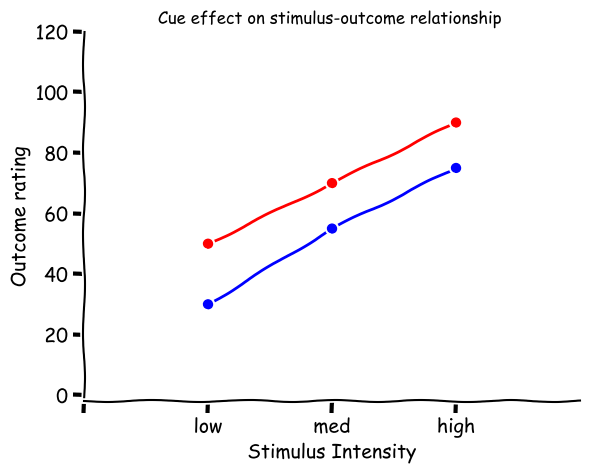

In [59]:
# addlabels.py

# import the required library
import matplotlib.pyplot as plt

# X and Y data
#numberofemp = [13, 200, 250, 300, 350, 400]
#year = [2011, 2012, 2013, 2014, 2015, 2016]

low_data = {'':np.nan,'low': 30, 'med': 55, 'high': 75}
high_data = {'':np.nan,'low': 50, 'med': 70, 'high': 90}
names = list(low_data.keys())
low_values = list(low_data.values())
high_values = list(high_data.values())
# plot a line chart
with plt.xkcd():
    # This figure will be in XKCD-style
    #fig1 = plt.figure()
    fig, ax = plt.subplots()


    plt.plot(names, low_values,marker="o", color = "b")
    plt.plot(names, high_values,marker="o", color = "r")

plt.xlabel("Stimulus Intensity")
plt.ylabel("Outcome rating")
plt.ylim(-2, 120)
plt.xlim(0,4)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# set label name of chart title
plt.title("Cue effect on stimulus-outcome relationship ")
plt.show()

# outcome ~ expect * cue

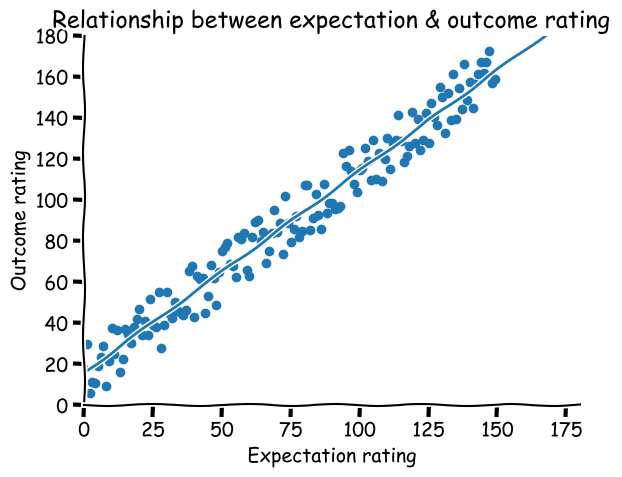

In [82]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

X = np.arange(0,150)
Y = X + np.random.rand(150)*30
results = sm.OLS(Y,sm.add_constant(X)).fit()


X_plot = np.linspace(0,180,20)
with plt.xkcd():
    fig, ax = plt.subplots()
    plt.plot(X_plot, X_plot * results.params[1] + results.params[0])
    plt.scatter(X,Y)
    plt.xlabel("Expectation rating")
    plt.ylabel("Outcome rating")
    plt.ylim(0,180)
    plt.xlim(0,180)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # set label name of chart title
    plt.title("Relationship between expectation & outcome rating")
    plt.show()

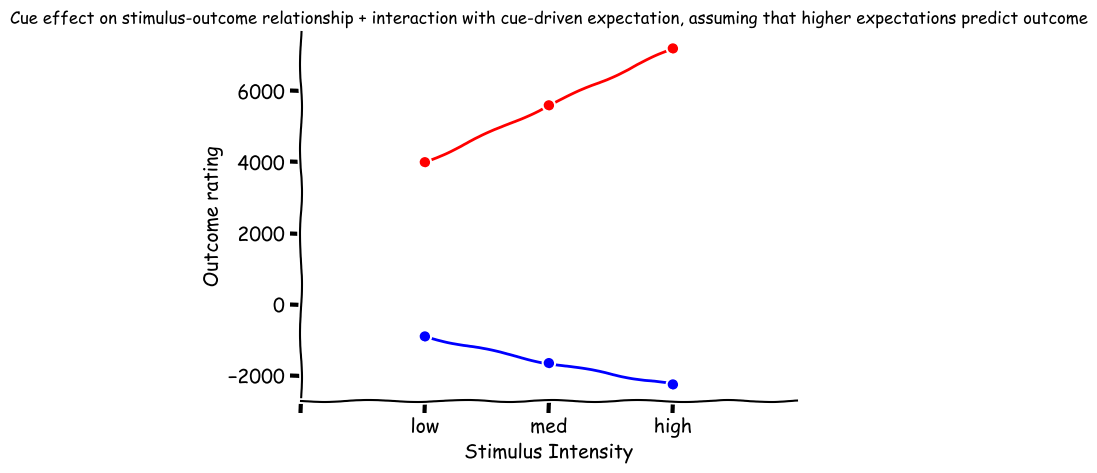

In [16]:
import matplotlib.pyplot as plt
low_data = {'':np.nan,'low': 30*-30, 'med': 55*-30, 'high': 75*-30}
high_data = {'':np.nan,'low': 50*80, 'med': 70*80, 'high': 90*80}
names = list(low_data.keys())
low_values = list(low_data.values())
high_values = list(high_data.values())
# plot a line chart
with plt.xkcd():
    fig, ax = plt.subplots()
    plt.plot(names, low_values,marker="o", color = "b")
    plt.plot(names, high_values,marker="o", color = "r")

plt.xlabel("Stimulus Intensity")
plt.ylabel("Outcome rating")
# plt.ylim(-2, 120)
plt.xlim(0,4)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# set label name of chart title
plt.title("Cue effect on stimulus-outcome relationship + interaction with cue-driven expectation, assuming that higher expectations predict outcome")
plt.show()

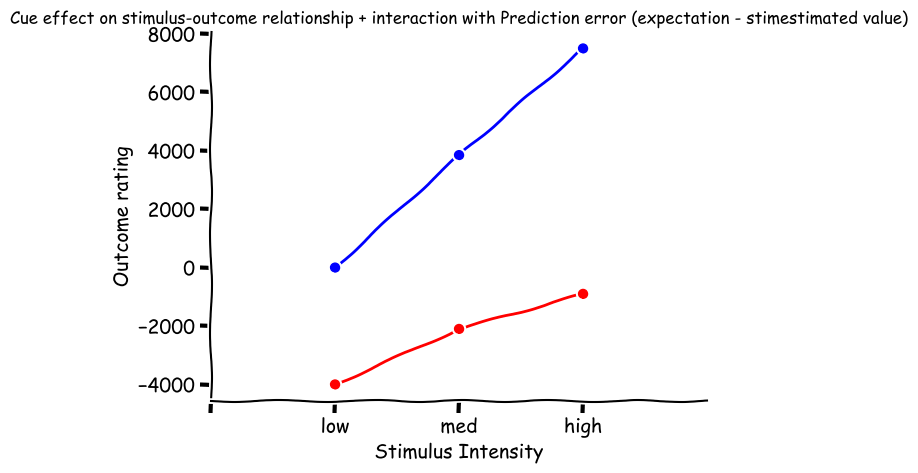

In [22]:
import matplotlib.pyplot as plt
low_data = {'':np.nan,'low': 30*0, 'med': 55*70, 'high': 75*100}
high_data = {'':np.nan,'low': 50*-80, 'med': 70*-30, 'high': 90*-10}
names = list(low_data.keys())
low_values = list(low_data.values())
high_values = list(high_data.values())
# plot a line chart
with plt.xkcd():
    fig, ax = plt.subplots()
    plt.plot(names, low_values,marker="o", color = "b")
    plt.plot(names, high_values,marker="o", color = "r")

plt.xlabel("Stimulus Intensity")
plt.ylabel("Outcome rating")
# plt.ylim(-2, 120)
plt.xlim(0,4)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# set label name of chart title
plt.title("Cue effect on stimulus-outcome relationship + interaction with Prediction error (expectation - stimestimated value)")
plt.show()

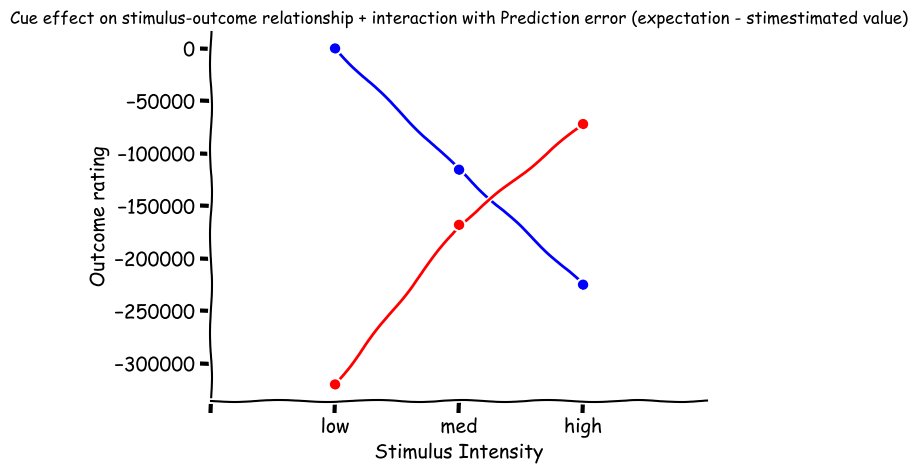

In [23]:
import matplotlib.pyplot as plt
low_data = {'':np.nan,'low': 30*0*-30, 'med': 55*70*-30, 'high': 75*100*-30}
high_data = {'':np.nan,'low': 50*-80*80, 'med': 70*-30*80, 'high': 90*-10*80}
names = list(low_data.keys())
low_values = list(low_data.values())
high_values = list(high_data.values())
# plot a line chart
with plt.xkcd():
    fig, ax = plt.subplots()
    plt.plot(names, low_values,marker="o", color = "b")
    plt.plot(names, high_values,marker="o", color = "r")

plt.xlabel("Stimulus Intensity")
plt.ylabel("Outcome rating")
# plt.ylim(-2, 120)
plt.xlim(0,4)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# set label name of chart title
plt.title("Cue effect on stimulus-outcome relationship + interaction with Prediction error (expectation - stimestimated value and expectation ratings")
plt.show()

In [ ]:
# addlabels.py

# import the required library
import matplotlib.pyplot as plt

# X and Y data
#numberofemp = [13, 200, 250, 300, 350, 400]
#year = [2011, 2012, 2013, 2014, 2015, 2016]


low_data = {'':np.nan,'cognitive1': 1,'cognitive2': 3,'cognitive3': 2, 'pain1': 20,'pain2': 25,'pain3': 30, 'vicarious': 0,'vicarious2': 3,'vicarious3': 4}
#high_data = {'':np.nan,'low': 50, 'med': 70, 'high': 90}
names = list(low_data.keys())
low_values = list(low_data.values())
#high_values = list(high_data.values())
# plot a line chart
with plt.xkcd():
    # This figure will be in XKCD-style
    #fig1 = plt.figure()
    fig, ax = plt.subplots()


    plt.plot(names, low_values,marker="o", color = "k")
   # plt.plot(names, high_values,marker="o", color = "r")

plt.xlabel("Task")
plt.ylabel("NPS (dot products)")
plt.ylim(-5, 30)
plt.xlim(0,9)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# set label name of chart title
plt.title("Cue effect on stimulus-outcome relationship ")
plt.show()

/Users/h/anaconda3/envs/spacetop_datalad/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ValueError: setting an array element with a sequence.

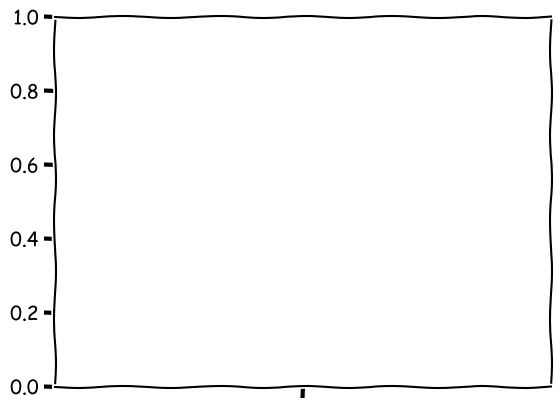